# XGBoost para classificação da direção de criptos

In [98]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [99]:
# Leitura dos dados
symbol = 'BTCUSDT'
period = '5m'
df = pd.read_csv(f'../../data/fechamentos/{symbol}_{period}_data.csv')

df.set_index('timestamp', inplace=True)
df.index = pd.to_datetime(df.index)

In [ ]:
# Preparação dos dados para classificação
periods_ahead = 2  # Períodos à frente para prever
df['target'] = np.where(df['close'].shift(-periods_ahead) > df['close'], 1, 0)  # 1 para alta, 0 para baixa
df.dropna(inplace=True) 

# Construção das features
def create_features(df):
    df = df.copy()
    epsilon = 1e-10  # Para evitar divisão por zero em contas com divisão

    df['return'] = df['close'].pct_change()
    df['volatility'] = df['return'].rolling(window=5).std()

    df['momentum_5'] = df['close'].diff(5)
    df['momentum_10'] = df['close'].diff(10)
    df['momentum_20'] = df['close'].diff(20)

    def williams_r(high, low, close, period=14):
        highest_high = high.rolling(window=period).max()
        lowest_low = low.rolling(window=period).min()
        return ((highest_high - close) / (highest_high - lowest_low + epsilon)) * -100
    df['williams_r'] = williams_r(df['high'], df['low'], df['close'])

    def rsi(close, period=14):
        delta = close.diff()
        gain = delta.clip(lower=0)
        loss = -delta.clip(upper=0)

        avg_gain = gain.ewm(alpha=1/period, min_periods=period, adjust=False).mean()
        avg_loss = loss.ewm(alpha=1/period, min_periods=period, adjust=False).mean()

        rs = avg_gain / (avg_loss + epsilon)
        return 100 - (100 / (1 + rs))
    df['rsi_7'] = rsi(df['close'], period=7)
    df['rsi_14'] = rsi(df['close'], period=14)

    df['ema_12'] = df['close'].ewm(span=12, adjust=False).mean()
    df['ema_26'] = df['close'].ewm(span=26, adjust=False).mean()
    
    df['macd'] = df['ema_12'] - df['ema_26']
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    df['macd_hist'] = df['macd'] - df['macd_signal']

    df['price_change'] = df['close'].diff()
    df['price_trend'] = df['close'].rolling(window=10).mean()

    df['volume_change'] = df['volume'].pct_change()
    df['volume_trend'] = df['volume'].rolling(window=10).mean()
    
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    
    price_direction = np.sign(df['close'].diff()).fillna(0)
    df['obv'] = (price_direction * df['volume']).cumsum()

    df['volume_sma_5'] = df['volume'].rolling(window=5).mean()
    df['volume_sma_10'] = df['volume'].rolling(window=10).mean()

    df['volume_pct_change_5'] = df['volume'].pct_change(periods=5)
    df['volume_pct_change_10'] = df['volume'].pct_change(periods=10)
    
    df['price_volume_ratio'] = df['volume'] / (df['high'] - df['low'] + epsilon)

    def bollinger_bands_new(series, window=20, num_std_dev=2):
        rolling_mean = series.rolling(window=window).mean()
        rolling_std = series.rolling(window=window).std()
        upper_band = rolling_mean + (rolling_std * num_std_dev)
        lower_band = rolling_mean - (rolling_std * num_std_dev)
        return upper_band, lower_band
    
    def atr_new(df_atr, window=14): 
        tr_high_low = df_atr['high'] - df_atr['low']
        tr_high_prev_close = abs(df_atr['high'] - df_atr['close'].shift())
        tr_low_prev_close = abs(df_atr['low'] - df_atr['close'].shift())
        tr = pd.DataFrame({'hl': tr_high_low, 'hpc': tr_high_prev_close, 'lpc': tr_low_prev_close}).max(axis=1)
        atr_val = tr.rolling(window=window).mean()
        return atr_val

    df['bb_upper'], df['bb_lower'] = bollinger_bands_new(df['close'])
    df['bb_upper_diff'] = df['bb_upper'] - df['close']
    df['bb_lower_diff'] = df['close'] - df['bb_lower']

    df['atr_14'] = atr_new(df, window=14)
     
    df.dropna(inplace=True)
    return df
      
# Aplicação da função
df = create_features(df)
df = df.drop(columns=['open', 'high', 'low', 'volume'])

In [101]:
# Divisão dos dados em treino e teste
tsv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tsv.split(df):
    X_train, X_test = df.iloc[train_index].drop(columns=['target']), df.iloc[test_index].drop(columns=['target'])
    y_train, y_test = df.iloc[train_index]['target'], df.iloc[test_index]['target']


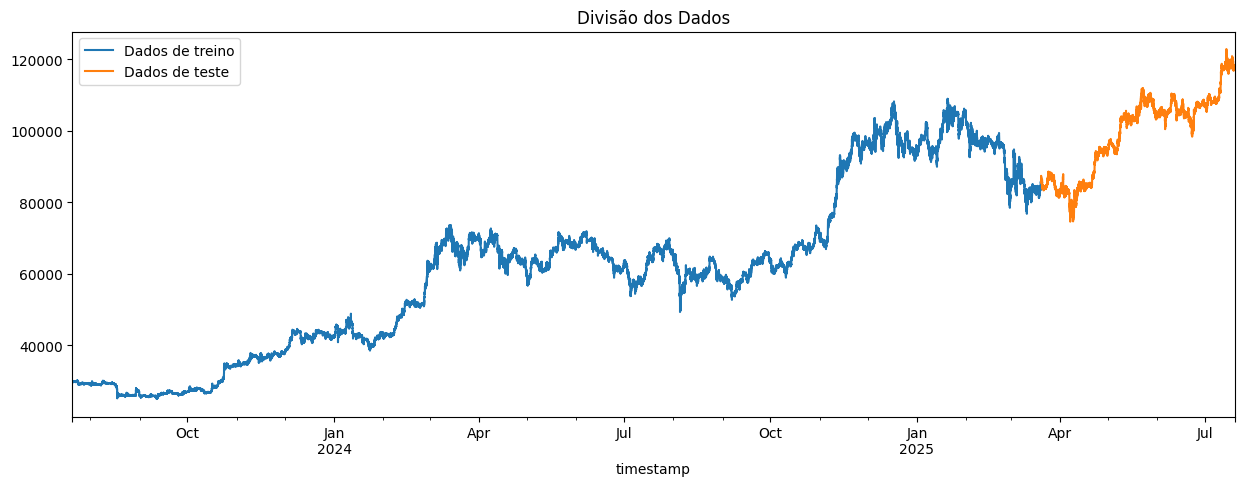

In [102]:
# Visualização da divisão dos dados
fig, ax = plt.subplots(figsize=(15, 5))
X_train['close'].plot(ax=ax, label='Dados de treino', title='Divisão dos Dados')
X_test['close'].plot(ax=ax, label='Dados de teste')
ax.legend(['Dados de treino', 'Dados de teste'])
plt.show()

In [103]:
# Criação do modelo XGBoost
model = xgb.XGBClassifier(n_estimators=5000, objective='binary:logistic', learning_rate=0.001, max_depth=5, subsample=0.8, colsample_bytree=0.5, gamma=0.1, early_stopping_rounds=20, random_state=1)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=100)

[0]	validation_0-logloss:0.69302
[100]	validation_0-logloss:0.69279
[200]	validation_0-logloss:0.69268
[262]	validation_0-logloss:0.69267


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.5
,device,None
,early_stopping_rounds,20
,enable_categorical,False
,eval_metric,None


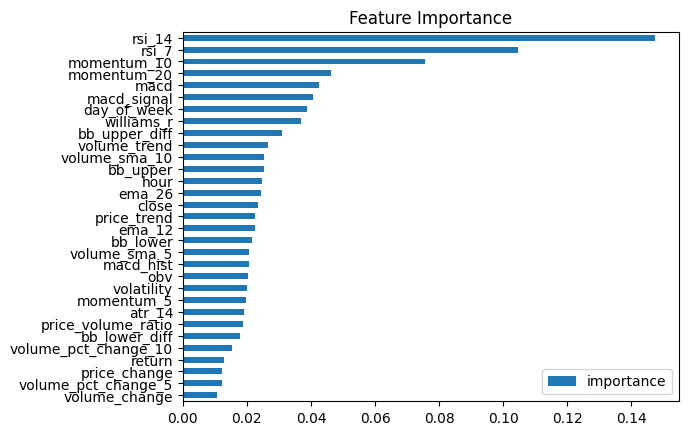

In [104]:
# Visualização da importância das features
fi = pd.DataFrame(data=model.feature_importances_,
             index=model.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

Acurácia: 51.39%
Precisão: 51.81%
F1 Score: 56.23%
Recall: 61.47%
AUC: 0.52


Text(0.5, 1.0, 'Matriz de Confusão')

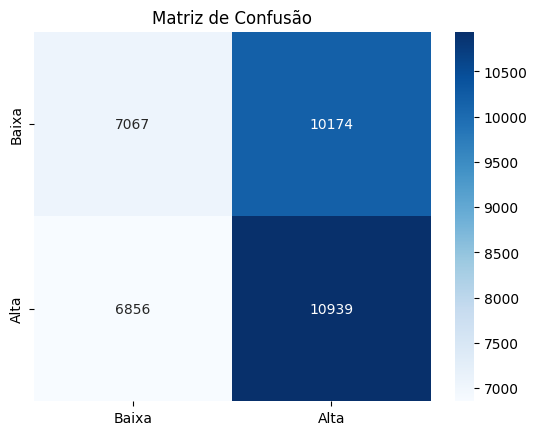

In [105]:
# Evaluação do modelo
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f'Acurácia: {acc*100:.2f}%')

prec = precision_score(y_test, y_pred)
print(f'Precisão: {prec*100:.2f}%')

f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1*100:.2f}%')

recall = recall_score(y_test, y_pred)
print(f'Recall: {recall*100:.2f}%')

auc = auc(*roc_curve(y_test, model.predict_proba(X_test)[:, 1])[:2])
print(f'AUC: {auc:.2f}')

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Baixa', 'Alta'], yticklabels=['Baixa', 'Alta'])
plt.title('Matriz de Confusão')